In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [68]:
criterion = torch.nn.CrossEntropyLoss()
input = torch.tensor([[3.2, 1.3,0.2, 0.8]],dtype=torch.float)
target = torch.tensor([0], dtype=torch.long)
criterion(input, target)
print(target.shape)

torch.Size([1])


In [9]:
prob = pd.read_csv('20long.csv')
prob["binary"] = prob["F3 probability"].round()
prob.binary = prob.binary.astype(int)

In [10]:
prob[(prob["F3 probability"] < 0) | (prob["F3 probability"] > 1)]

,seq,F1 probability,F2 probability,F3 probability,F4 probability,F5 probability,F6 probability,F7 probability,F8 probability,binary


In [11]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACUGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'U':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [12]:
one_hot_encode((prob["seq"][0]))

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [14]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

In [15]:
full_train_df, test_df = quick_split(prob)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

train_df.head(10)

Train: (7482, 10)
Val: (1871, 10)
Test: (2339, 10)


,seq,F1 probability,F2 probability,F3 probability,F4 probability,F5 probability,F6 probability,F7 probability,F8 probability,binary
0,AAUACGAGAGGAGGAAGGCAAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0
1,CACAUAACUGGAGACACAGCAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.008088,0.991912,0
2,AUGUAAUAGGGAGGAGAAGAAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0
3,UUACUACGUGGAGAAAAGAGAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.016631,0.983369,0
4,UAACAAUCGGAGGCAAUCGUAUG,0.0,0.0,0.000463,0.000000,0.0,0.0,0.000000,0.999537,0
5,AGAGAUAGAGGAGGAUUAAAAUG,0.0,0.0,0.000000,0.000606,0.0,0.0,0.000000,0.999394,0
6,AGAGAAAGAGGAGGGCAAAGAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0
7,AUAUGGUGGAGGAAAUAGUCAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.012675,0.987325,0
8,UGAAUAGGAGGAUUAAGCGAAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.126444,0.873556,0
9,GUAUGAAGAGGAGAAAAGGUAUG,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0


In [16]:
prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11692 entries, 0 to 11691
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seq             11692 non-null  object 
 1   F1 probability  11692 non-null  float64
 2   F2 probability  11692 non-null  float64
 3   F3 probability  11692 non-null  float64
 4   F4 probability  11692 non-null  float64
 5   F5 probability  11692 non-null  float64
 6   F6 probability  11692 non-null  float64
 7   F7 probability  11692 non-null  float64
 8   F8 probability  11692 non-null  float64
 9   binary          11692 non-null  int32  
dtypes: float64(8), int32(1), object(1)
memory usage: 867.9+ KB


In [17]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='F3 probability'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

In [18]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='F3 probability',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [19]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

In [20]:
# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        return out

    
# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 
    def forward(self, xb):
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.permute(0,2,1) 
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out
    
    # __FOOTNOTE 1__

In [154]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out.shape:",xb_out.shape)
        print("xb_out.squeeze(0):",xb_out.squeeze(0).shape)
        print("yb.squeeze(1).shape",yb.squeeze(1).shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
        #print(yb)
        print("yb.long.squeeze(1):",yb.long().squeeze(1).shape)
        print()
        print(yb.long().dtype)
        #sample_tensor=sample_tensor.type(torch.FloatTensor) 
        
        
    yb_long = yb.long().squeeze(1)
    m = torch.nn.Sigmoid()
    #loss = loss_func(xb_out, yb.float()) # for MSE/regression
    # __FOOTNOTE 2__
    loss = loss_func(xb_out, yb.float()) # for BCE/classification
    """staclOverflow разъяснение для размеров и типа входных данных для кросс энтропии
    https://stackoverflow.com/questions/53455780/pytorch-lstm-target-dimension-in-calculating-cross-entropy-loss/53458159#53458159
    BCE вместо кросс энтропии https://discuss.pytorch.org/t/crossentropy-in-pytorch-getting-target-1-out-of-bounds/71575
    
    """
    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
    
def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt,verbose = False)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb,verbose =False)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.BCEWithLogitsLoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses

In [155]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE
)

E0 | train loss: 0.555 | val loss: 0.495
E1 | train loss: 0.488 | val loss: 0.479
E2 | train loss: 0.480 | val loss: 0.477
E3 | train loss: 0.479 | val loss: 0.476
E4 | train loss: 0.478 | val loss: 0.476
E5 | train loss: 0.477 | val loss: 0.475
E6 | train loss: 0.476 | val loss: 0.475
E7 | train loss: 0.476 | val loss: 0.474
E8 | train loss: 0.475 | val loss: 0.474
E9 | train loss: 0.474 | val loss: 0.473
E10 | train loss: 0.474 | val loss: 0.473
E11 | train loss: 0.473 | val loss: 0.473
E12 | train loss: 0.473 | val loss: 0.472
E13 | train loss: 0.472 | val loss: 0.472
E14 | train loss: 0.472 | val loss: 0.472
E15 | train loss: 0.471 | val loss: 0.471
E16 | train loss: 0.471 | val loss: 0.471
E17 | train loss: 0.471 | val loss: 0.471
E18 | train loss: 0.470 | val loss: 0.471
E19 | train loss: 0.470 | val loss: 0.470
E20 | train loss: 0.470 | val loss: 0.470
E21 | train loss: 0.469 | val loss: 0.470
E22 | train loss: 0.469 | val loss: 0.470
E23 | train loss: 0.469 | val loss: 0.470
E2

In [151]:
def quick_loss_plot(data_label_list,loss_type="BCE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

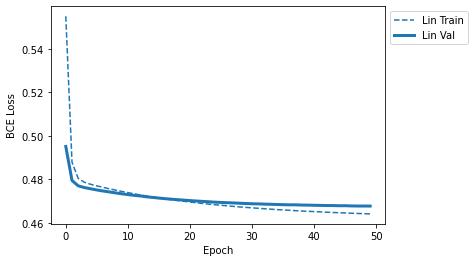

In [156]:
lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

In [160]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE
)

E0 | train loss: 0.513 | val loss: 0.481
E1 | train loss: 0.478 | val loss: 0.481
E2 | train loss: 0.478 | val loss: 0.480
E3 | train loss: 0.477 | val loss: 0.479
E4 | train loss: 0.476 | val loss: 0.479
E5 | train loss: 0.475 | val loss: 0.478
E6 | train loss: 0.475 | val loss: 0.478
E7 | train loss: 0.474 | val loss: 0.477
E8 | train loss: 0.473 | val loss: 0.477
E9 | train loss: 0.473 | val loss: 0.476
E10 | train loss: 0.472 | val loss: 0.475
E11 | train loss: 0.472 | val loss: 0.475
E12 | train loss: 0.471 | val loss: 0.475
E13 | train loss: 0.471 | val loss: 0.474
E14 | train loss: 0.470 | val loss: 0.474
E15 | train loss: 0.470 | val loss: 0.473
E16 | train loss: 0.469 | val loss: 0.473
E17 | train loss: 0.469 | val loss: 0.473
E18 | train loss: 0.468 | val loss: 0.472
E19 | train loss: 0.468 | val loss: 0.472
E20 | train loss: 0.467 | val loss: 0.472
E21 | train loss: 0.467 | val loss: 0.471
E22 | train loss: 0.467 | val loss: 0.471
E23 | train loss: 0.466 | val loss: 0.471
E2

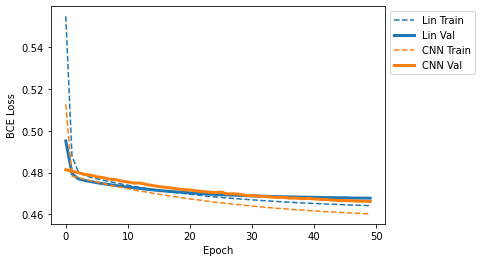

In [161]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

In [147]:
oracle = dict(test_df[['seq','F3 probability']].values)

def quick_seq_pred(model, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    
    '''
    
    df = pd.DataFrame(data = {'seq': [], 'pred': [], 'actual': [], "diff": []})
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = pred.item() - actual
        #print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")
        #df2 = pd.DataFrame(data = {'seq': [dna], 'pred': [pred.item()], 'actual': [actual]})
        df = df.append({'seq': dna, 'pred': pred.item(), 'actual': actual, "diff": diff}, ignore_index = True)
    return df
    

def quick_8mer_pred(model, oracle):

    for seqs in oracle.keys():
        quick_seq_pred(model, oracle, oracle)
        

In [157]:
df = quick_seq_pred(model_lin, oracle.keys(), oracle)

In [158]:
df.head(20)

,seq,pred,actual,diff
0,UGAAUUAGGAGGGUAUAGAAAUG,-2.018470,0.0,-2.018470
1,GUACGAAGAGGAGGAAUAUAAUG,-2.104053,0.0,-2.104053
2,AGAAGAGGAGGACUGAGAUGAUG,-2.026808,0.0,-2.026808
3,UUGGAGAAUAGGAGGAAAAGAUG,-1.472379,0.0,-1.472379
4,ACGAGAAGAGGAGGAGAAAAAUG,-1.884343,0.0,-1.884343
5,AUAGAAGCGGAGGAAUAAUCAUG,-1.577263,0.0,-1.577263
6,GUGAGUAGAGGAGAUAUAUAAUG,-1.920333,0.0,-1.920333
7,AGAGAGAGGAGAGAGAAAAAAUG,-1.835910,0.0,-1.835910
8,AUACGAGAGAGGAUAAUGAGAUG,-1.957115,0.0,-1.957115
9,AAACUGAGGAGAGAUAAAGAAUG,-2.212657,0.0,-2.212657


In [159]:
df.tail(20)

,seq,pred,actual,diff
2319,UGUUGAAGUCCCUGUUACGUAUG,-1.334727,0.0,-1.334727
2320,UUCUAUAUGGGACUAAACGAAUG,-2.040472,0.0,-2.040472
2321,AACCCAUAGGGGCACUAAACAUG,-2.178013,1.0,-3.178013
2322,AAGCAUGUAUAGGUAAAGAAAUG,-1.467031,1.0,-2.467031
2323,AAUGAAAGGGAAAGAAAGAGAUG,-1.598732,1.0,-2.598732
2324,AGAUAGACUGGAAGAACAUGAUG,-1.755444,1.0,-2.755444
2325,AUAUGCUAUGAGCGGUGGUUAUG,-1.351755,1.0,-2.351755
2326,CAGUAUAAAGGAAUAAAAAGAUG,-1.670071,1.0,-2.670071
2327,GAUAAAAGGUGAUUCUUAGUAUG,-1.551362,1.0,-2.551362
2328,GUGAAGAGGUAUAGAGAAGGAUG,-1.151022,1.0,-2.151022
